In [69]:
"""
This program uses numerical integration method to solve a differential
equation governing a series RLC circuit and looks at the the behavior
of the underdamped, critically damped, and overdamped circuits.
This program is divided into 3 parts. Part 1 generates a random
inductance and capacitance values. Based on those it will then generate
the resistor values for the 3 states mentioned above. The second part of
program uses numerical integration to find the current at time t with for
the 3 states with the given initial values. The last part of the program
shows the dependence of the steady state amplitude of current on the
frequency of the sinusoidal driving voltage.
"""

import numpy as np

# Generate random values to be used to create
# random inductance(L)
a_l = np.random.randint(10, 99 + 1)
b_l = np.random.randint(-9, -5 + 1)
L = a_l * (10**b_l)  # Henries

# Generate random values to be used to create
# random capacitance(C)
a_c = np.random.randint(10, 99 + 1)
b_c = np.random.randint(-9, -5 + 1)
C = a_c * (10**b_c)

# Determine the values of R
r_under = 0.2 * np.sqrt(L / C)  # Resistor value - underdamped
r_critical = 2 * np.sqrt(L / C)  # Resistor value - critically damped
r_over = 10 * np.sqrt(L / C)  # Resistor value - overdamped
r_arr = np.array([[r_under, "Underdamped"], [r_critical, "Critically Damped"],
                  [r_over, "Overdamped"]],
                 dtype=object)  # Array containing all R values


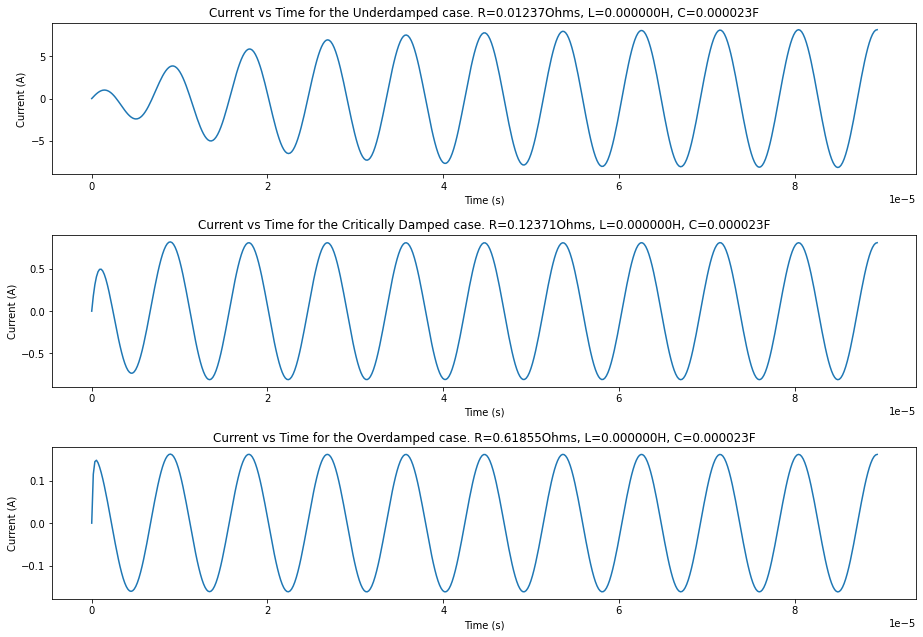

In [72]:
from scipy.integrate import solve_ivp
from matplotlib.pyplot import figure, subplot, subplots_adjust,\
                              title, plot, ylabel, xlabel, legend

# Constants and initial values definition

omega0 = 1 / np.sqrt(L * C)  # Frequency at time 0
omega = omega0  # Frequency
v0 = 0.1  # Circuit voltage in volts
q0 = 0  # Initial charge at time 0
i0 = 0  # Initial current at time 0
period = (2 * np.pi) / omega  # One period
initial_arr = np.array([q0, i0])  # Initial values q0 and i0
t_arr = np.linspace(0, period * 10, 500)  # Time array defined based on period

# Function definitions

def dqqt_arr(t, initial_array, R, w):
    """
    A functions that returns a numpy array containing
    the first and second derivatives of charge based on
    the given initial conditions

    Keyword arguments:
        t -- time in seconds (can be a single number or an array of numbers)
        initial_array -- The initial conditions of the differential equation
        R -- The given resistor of the circuit
        w -- The omega (frequency) value

    Returns:
        A numpy array containing the first and second derivative
        of charge respectively.
    """

    q = initial_array[0]  # Charge q

    # First order derivative of charge
    dq_dt = initial_array[1]  # Current I = dq/dt

    # Calculate the second order derivative of charge d2q/dt2
    dq2_dt2 = 1 / L * v0 * np.cos(w * t) - (R / L * dq_dt) - (1 / (L * C) * q)

    # Return an array containing first and second order derivatives
    return np.array([dq_dt, dq2_dt2])


# An array to store the solutions of each resistor value
# when solving the differential equation.
solutions = np.array([], dtype=object)

# Prepare the plot figure to be used in the loop
figure(figsize=(15, 10))

# Plot variables
plt_nrows = len(r_arr)  # The num of rows of the subplots
plt_ncols = 1  # The num of columns of the subplot

# Add plot spacing
subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# Loop over each resistor value and case and solve the differential equation
# based on them. Append the values to the solutions array.
for index, resistor in enumerate(r_arr):
    # Solve the differential equation using solve_ivp. This function
    # numerically integrates a system of ordinary differential
    # equations given an initial value. In this loop this function
    # in run for each resistor value (under, critical, and over) damped.
    # The return values contain the current of the circuit at time t.
    sol = solve_ivp(dqqt_arr, (t_arr[0], t_arr[-1]),
                    initial_arr,
                    t_eval=t_arr,
                    args=(resistor[0], omega),
                    method='LSODA')

    # Append to the solutions variable
    solutions = np.append(solutions, sol)

    # Create the subplot for each resistor
    subplot(plt_nrows, plt_ncols, index + 1)

    # Grab the current values returned by the solve_ivp
    curr_values = sol['y'][1]

    # Plot the time vs current values solved by the solve_ivp
    plot(t_arr, curr_values)

    # Add plot information (title, x and y label)
    title(f"Current vs Time for the {resistor[1]} case. "
              f"R={resistor[0]:.5f}Ohms, L={L:.6f}H, C={C:.6f}F")
    ylabel("Current (A)")
    xlabel("Time (s)")

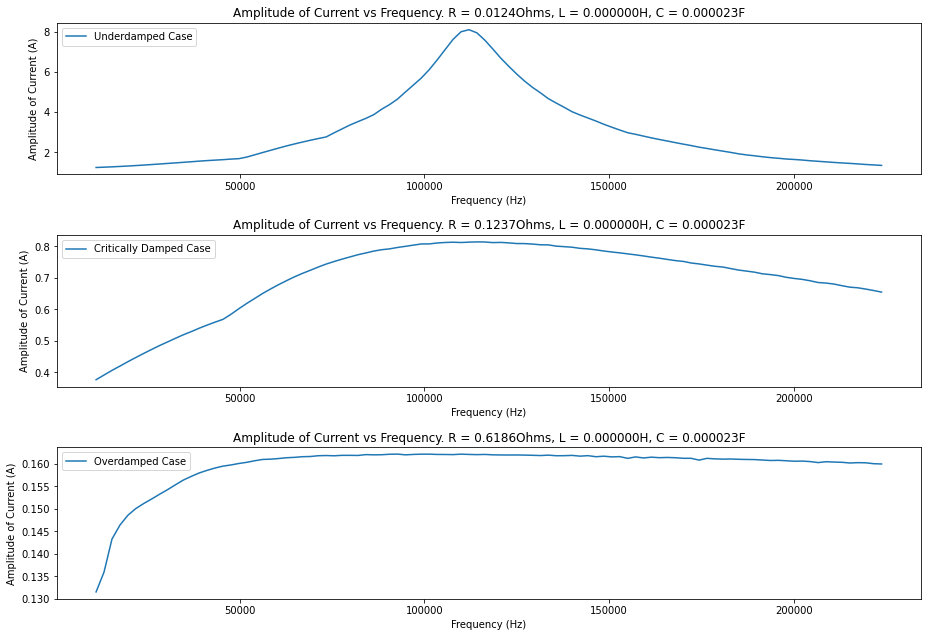

In [73]:

# Define variables and arrays

interval = 100 # The number of divisions of the frequency range

# The range of frequency.
omega_list = np.linspace(0.1 * omega, 2 * omega, interval)

# Create the current amplitude array for the under, critical
# and over damped cases with prefilled values and data types
# for eliminating the need of appending and re-assigning memory.

# The under damped current amplitudes
amp_under = np.linspace(0, 1, interval, dtype=np.float32) 

# The critically damped current amplitudes
amp_critical = np.linspace(0, 1, interval, dtype=np.float32)

# The over damped current amplitudes
amp_over = np.linspace(0, 1, interval, dtype=np.float32)

# An array containing a reference of all 3 cases of current amplitudes.
amp_arr = np.array([amp_under, amp_critical, amp_over], dtype=object)

# Loop over all the omega values
for i, w in enumerate(omega_list):
    # Loop over all resistor values (under, critical,
    # and over damped)
    for j, resistor in enumerate(r_arr):
        # Numerically integrate over the differential equation
        # and return the current values based on each case of
        # resistance (under, critical, over) damped and the
        # different value of omega.
        sol = solve_ivp(dqqt_arr, (t_arr[0], t_arr[-1]),
                    initial_arr,
                    t_eval=t_arr,
                    args=(resistor[0], w),
                    method='LSODA')
        
        # Get a reference to the current values returned by the
        # solve_ivp for faster access in calculations. Store the
        # current values in a variable.
        curr_values = sol['y'][1]

        # Calculate the amplitude of the current from the 
        # integrated values returned by the solve_ivp and
        # store them in its respective array to be plotted.
        max_minus_min_curr = np.max(curr_values) - np.min(curr_values)
        amp_arr[j][i] = max_minus_min_curr / 2

# Convert the omega to frequency in Hertz (w = 2 * pi * f)
omega_list = omega_list / (2 * np.pi)

# Create the plot figure and set the figure size
figure(figsize=(15, 10))

# Plot constants definitions
plt_f_nrows = 3 # Num of subplot rows
plt_f_ncols = 1 # Num of subplot columns

# Add plot spacing
subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)


# For each of the amplitudes create a subplot and plot them
for i, amp in enumerate(amp_arr):
    # Create subplot for each case (under, critical, and over damped)
    subplot(plt_f_nrows, plt_f_ncols, i + 1)

    # Plot the amplitudes of each case vs the frequency
    plot(omega_list, amp)
    
    # Add plot title and axes labels
    title(f"Amplitude of Current vs Frequency. "
              f"R = {r_arr[i][0]:.4f}Ohms, L = {L:.6f}H, C = {C:.6f}F")
    xlabel("Frequency (Hz)"); ylabel("Amplitude of Current (A)")

    # Add a legend to show which resistance case this plot illustrates
    legend([f"{r_arr[i][1]} Case"], loc="upper left")

